# Pytorch Notebook

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pyro
import pyro.distributions as dist
import pyro.optim as optim_pyro

import torchvision
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

## Pytorch basics
If you are using jupyterlab, enable "show contextual help" for checking the definitions of functions!

In [145]:
# Get variables
x = torch.ones(3, 4)

print(x)
print(x.view(1, 12))
print(x.view(2, -1))

y = torch.rand(3, 4)
z = x + y

print(z.size())
print(z)

# Matrix product
x = torch.randn(4, 4)
v = torch.randn(1, 4)
z = torch.mm(v, x)
print(z)
z = torch.matmul(v, x)
print(z)

# Dot product
x = torch.randn(4)
v = torch.randn(4)
z = torch.dot(x, v)
print(z)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
torch.Size([3, 4])
tensor([[1.8075, 1.1918, 1.0777, 1.3787],
        [1.8548, 1.0903, 1.9512, 1.2047],
        [1.6718, 1.4737, 1.1979, 1.5236]])
tensor([[-0.3725,  1.7241, -0.5482, -0.5179]])
tensor([[-0.3725,  1.7241, -0.5482, -0.5179]])
tensor(-2.4792)


In [3]:
# Auto grad basics
x = torch.ones(1, 2, requires_grad=True)
print(x)

y = 2 * x + 2
print(y)
print(y.grad_fn)

z = y * y * 3
out = z.mean()
print(z, out)

# , detach

tensor([[1., 1.]], requires_grad=True)
tensor([[4., 4.]], grad_fn=<AddBackward0>)
tensor([[48., 48.]], grad_fn=<MulBackward0>) tensor(48., grad_fn=<MeanBackward0>)


In [4]:
x = torch.randn(2, 2)  # <-- for constants, requires_grad is initially False
x = ((x * 3) / (x - 1))
print(x.requires_grad)

x.requires_grad_(True) # <-- Switch requires_grad by hand
print(x.requires_grad)

y = (x ** 2).sum()
print(y.grad_fn)

False
True


### backward

In [5]:
x = torch.ones(2, 2, requires_grad=True) # <-- enable grad calculation
print(x)
print(x.requires_grad)
print(x.grad_fn)
print("---")

y = x + 2
print(y)
print(y.requires_grad)
print(y.grad_fn)
print("---")

z = y * y * 3
out = z.mean()
print(z, out)
print(z.requires_grad, out.requires_grad)
print(z.grad_fn, out.grad_fn)
print("---")

out.backward() # <-- run backprop
print(x.grad)

# running backward() multiple times elicit an error
#out.backward() # <-- run backprop
#print(x.grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
True
None
---
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
True
---
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
True True
<MulBackward0 object at 0x12dbbeb00> <MeanBackward0 object at 0x12dbbebe0>
---
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### vector-Jacobian product
This characteristic of vector-Jacobian product makes it very convenient to feed external gradients into a model that has non-scalar output.

Now in this case y is no longer a scalar. torch.autograd could not compute the full Jacobian directly, but if we just want the vector-Jacobian product, simply pass the vector to backward as argument. $J$ is jacobian. and ${\rm x\_grad} = J^\top v$. If the backward target is a scalar function, $v = (\frac{l}{y_1}, \cdots, \frac{l}{y_m})^\top$

In [6]:
x = torch.ones(3, requires_grad=True)
y = x * 2

print(f"norm : {y.data.norm()}")
print(y)
while y.data.norm() < 1000:
    y = y * 2
    print(f"norm : {y.data.norm()}")
    print(y)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)
print(x.grad)

norm : 3.464101552963257
tensor([2., 2., 2.], grad_fn=<MulBackward0>)
norm : 6.928203105926514
tensor([4., 4., 4.], grad_fn=<MulBackward0>)
norm : 13.856406211853027
tensor([8., 8., 8.], grad_fn=<MulBackward0>)
norm : 27.712812423706055
tensor([16., 16., 16.], grad_fn=<MulBackward0>)
norm : 55.42562484741211
tensor([32., 32., 32.], grad_fn=<MulBackward0>)
norm : 110.85124969482422
tensor([64., 64., 64.], grad_fn=<MulBackward0>)
norm : 221.70249938964844
tensor([128., 128., 128.], grad_fn=<MulBackward0>)
norm : 443.4049987792969
tensor([256., 256., 256.], grad_fn=<MulBackward0>)
norm : 886.8099975585938
tensor([512., 512., 512.], grad_fn=<MulBackward0>)
norm : 1773.6199951171875
tensor([1024., 1024., 1024.], grad_fn=<MulBackward0>)
tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


### Stop autograd by wrapping with no_grad

In [7]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
print((x ** 2).requires_grad)

# stop autograd and block 
with torch.no_grad():
    print((x ** 2).requires_grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
True
False


### Use detach() to get a "new" Tensor with the same content but that does not require gradient

In [8]:
x = torch.tensor([2], dtype=torch.float, requires_grad=True)
y = torch.tensor([3], dtype=torch.float, requires_grad=True)

out = (x ** 2) * (y ** 2)
print(out.requires_grad)
z = out.detach()
print(z.requires_grad)

# z.backward() # <-- return an error

True
False


## Autograd and some specific topics

### Define Fully Connected Feed Forward NN $f_{\theta}$ 

In [44]:
class FFNetwork(nn.Module):
    # One input, one output, two hidden layers

    def __init__(self, n_hidden):
        super(FFNetwork, self).__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.fc3 = nn.Linear(in_features=n_hidden, out_features=1)
    
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        out = self.fc3(h)
        return out

ffnet = FFNetwork(10)
print(ffnet)

params = list(ffnet.parameters())
#print(params)
print(f"num_params : {len(params)}")
for i in range(len(params)):
    print(params[i].size())
print("---")

# Trial input
input = torch.randn(3, 1)
print(input)
out = ffnet(input) # same with ffnet.forward(input)
print(out)

FFNetwork(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
num_params : 6
torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])
---
tensor([[-1.0939],
        [-0.3754],
        [ 0.6130]])
tensor([[-0.3120],
        [-0.1881],
        [-0.1187]], grad_fn=<AddmmBackward>)


### Calculate Loss $L(\theta)$

In [100]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)
print(input.requires_grad)
print(target.requires_grad)

ffnet = FFNetwork(10)

# Mean squared error of the minibatch with 10 samples
loss_func = nn.MSELoss()

out = ffnet(input)
loss = loss_func(out, target)
print(loss)

False
False
tensor(1.0311, grad_fn=<MseLossBackward>)


### Calculate $\nabla_\theta L(\theta, x)|_{x=x_0}$

In [101]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)

ffnet = FFNetwork(10)

out = ffnet(input)
loss_func = nn.MSELoss()
loss = loss_func(out, target)

ffnet.zero_grad()
print("ffnet.fc1.[param].grad before backward")
print(ffnet.fc1.bias.grad)
print(ffnet.fc1.weight.grad)
print("---")

loss.backward()
print("ffnet.fc1.[param].grad after backward")
print(ffnet.fc1.bias.grad)
print(ffnet.fc1.weight.grad)

ffnet.fc1.[param].grad before backward
None
None
---
ffnet.fc1.[param].grad after backward
tensor([ 1.9350e-02, -1.6908e-01,  1.3575e-02, -9.5872e-05,  9.6607e-05,
        -2.0997e-01,  2.9409e-01,  2.8184e-02,  5.8546e-02,  5.0708e-04])
tensor([[-0.0449],
        [ 0.0268],
        [-0.0186],
        [ 0.0003],
        [ 0.0008],
        [-0.2010],
        [ 0.1400],
        [ 0.0351],
        [ 0.0057],
        [ 0.0042]])


### Update $\theta \leftarrow \theta + \alpha \nabla_\theta L(\theta, x)|_{x=x_0}$

#### Individual parameter update

tensor([[0.9231],
        [0.9233],
        [1.3031],
        [0.8204],
        [0.9104],
        [0.9550],
        [0.8514],
        [0.9461],
        [1.0208],
        [0.8067]])


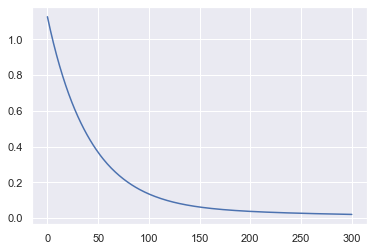

In [102]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)

ffnet = FFNetwork(n_hidden=50)
learning_rate = 0.001

out = ffnet(input)
loss_func = nn.MSELoss()
loss = loss_func(out, target)

loss_hist_sgd = [loss.detach()]
for i in range(300):
    ffnet.zero_grad()
    loss.backward()
    for f in ffnet.parameters():
        f.data.sub_(f.grad.data * learning_rate)
        
    loss = loss_func(ffnet(input), target)
    loss_hist_sgd.append(loss.detach())

plt.plot(loss_hist_sgd)
out = ffnet.forward(input)
print(out.detach())

#### Update by using Optimizer

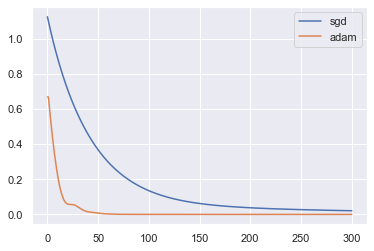

In [103]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)

ffnet = FFNetwork(50)
learning_rate = 0.001

optimizer = optim.Adam(ffnet.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()
loss = loss_func(ffnet(input), target)
loss_hist_adam = [loss.detach()]

for i in range(300):
    optimizer.zero_grad()
    loss = loss_func(ffnet(input), target)
    loss_hist_adam.append(loss.detach())
    loss.backward()
    optimizer.step()

plt.plot(loss_hist_sgd, label="sgd")
plt.plot(loss_hist_adam, label="adam")
plt.legend(loc="best")

### Update weight by minibatch $\frac{1}{N} \sum_{n=1}^N \nabla_\theta L(\theta, x)|_{x=x_n}$

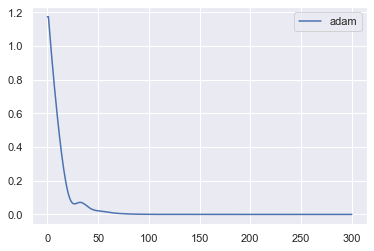

In [104]:
n = 50
input = torch.randn(n, 1)
target = torch.ones(n, 1)

ffnet = FFNetwork(50)
learning_rate = 0.001

optimizer = optim.Adam(ffnet.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()
loss = loss_func(ffnet.forward(input), target)
loss_hist_adam = [loss.detach()]

for i in range(300):
    optimizer.zero_grad()
    loss = loss_func(ffnet.forward(input), target)
    loss_hist_adam.append(loss.detach())
    loss.backward()
    optimizer.step()

plt.plot(loss_hist_adam, label="adam")
plt.legend(loc="best")

### Calculate $\nabla_x L(\theta, x)|_{x=x_0}$

In [105]:
input = torch.zeros(1, requires_grad=True)
input_0 = torch.zeros_like(input, requires_grad=False)
target = torch.ones(1)

ffnet = FFNetwork(50)
learning_rate = 0.1

optimizer = optim.Adam([input], lr=learning_rate)
# Update with network parameters
#optimizer = optim.Adam([input] + [w for w in ffnet.parameters()], lr=learning_rate)

loss_func = nn.MSELoss()
y = ffnet(input)
optimizer.zero_grad()

sum_w = 0
for w in ffnet.parameters():
    sum_w += torch.sum(torch.abs(w))

loss = loss_func(y, target)
loss.backward()
optimizer.step()

print("weight gradient ---")
for w in ffnet.parameters():
    sum_w -= torch.sum(torch.abs(w))
print(f"Absolute difference of weight from initial weights : {sum_w}")
print("input gradient ----- ")
print(input.grad)
print(input - input_0)

weight gradient ---
Absolute difference of weight from initial weights : -1.2874603271484375e-05
input gradient ----- 
tensor([-0.0041])
tensor([0.1000], grad_fn=<SubBackward0>)


### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$

weight gradient ---
Absolute difference of weight from initial weights : -6.541609764099121e-06
input gradient ----- 
tensor([0.])
tensor([-3.5146], grad_fn=<SubBackward0>)


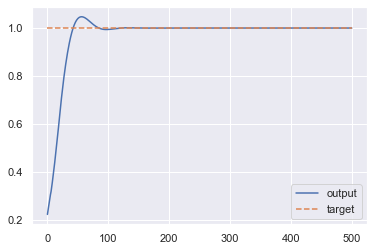

In [125]:
input = torch.zeros(1, requires_grad=True)
target = torch.ones(1)

ffnet = FFNetwork(50)
learning_rate = 0.1

optimizer = optim.Adam([input], lr=learning_rate)
# Update with network parameters
#optimizer = optim.Adam([input] + [w for w in ffnet.parameters()], lr=learning_rate)

loss_func = nn.MSELoss()
y = ffnet(input)
hist_adam = [y.detach()]

sum_w = 0
for w in ffnet.parameters():
    sum_w -= torch.sum(torch.abs(w))

# Update Rule
for i in range(500):
    optimizer.zero_grad()
    loss = loss_func(y, target)
    loss.backward()
    optimizer.step()
    y = ffnet(input)
    hist_adam.append(y.detach())

plt.plot(hist_adam, label="output")
plt.plot([1.0]*len(hist_adam), "--", label="target")
plt.legend(loc="best")

print("weight gradient ---")
for w in ffnet.parameters():
    sum_w += torch.sum(torch.abs(w))
print(f"Absolute difference of weight from initial weights : {sum_w}")
print("input gradient ----- ")
print(input.grad)
print(input - input_0)

### Copy $\theta_1$ to $\theta_2$

In [96]:
n = 50
learning_rate = 0.001

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet1 = FFNetwork(50)

# Copy Network
ffnet2 = FFNetwork(50)
ffnet2.load_state_dict(ffnet1.state_dict())

<All keys matched successfully>

### Copy $\theta_1$ to $\theta_2$ and update only $\theta_1$ by $\theta \leftarrow \theta + \alpha \nabla_\theta L(\theta, x)|_{x=x_0}$

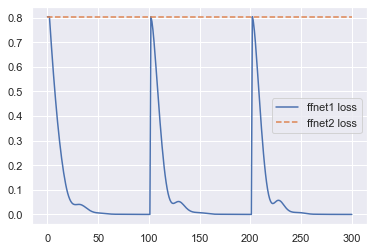

In [97]:
n = 50
learning_rate = 0.001

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet1 = FFNetwork(50)

# Copy Network
ffnet2 = FFNetwork(50)
ffnet2.load_state_dict(ffnet1.state_dict())

optimizer = optim.Adam(ffnet1.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()
loss1 = loss_func(ffnet1(input), target)
loss1_hist_adam = [loss1.detach()]
loss2 = loss_func(ffnet2(input), target)
loss2_hist_adam = [loss2.detach()]

for i in range(300):
    optimizer.zero_grad()
    
    loss1 = loss_func(ffnet1(input), target)
    loss1_hist_adam.append(loss1.detach())
    loss2 = loss_func(ffnet2(input), target)
    loss2_hist_adam.append(loss2.detach())
    
    loss1.backward()
    optimizer.step()
    
    # Copy 2nd Nework Parameters into 1st Network every 100 steps
    if i % 100 == 0:
        ffnet1.load_state_dict(ffnet2.state_dict())

plt.plot(loss1_hist_adam, label="ffnet1 loss")
plt.plot(loss2_hist_adam, "--", label="ffnet2 loss")
plt.legend(loc="best")

### Stochastic sampling from $f_\theta(x)$

(-1.0, 1.0)

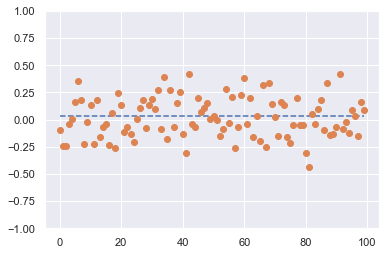

In [165]:
n = 1
learning_rate = 0.001

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet = FFNetwork(50)

mu = ffnet(input)
sigma = 0.2

sample_list = []
for i in range(100):
    sample = mu + sigma * torch.randn_like(mu)
    sample_list.append(sample.detach()[0])

plt.plot([mu.detach()[0]] * 100, "--", label="mean")
plt.plot(sample_list, "o", label="samples")
plt.ylim([-1, 1])

### Inject noise (reparametrization trick) and cal grad $\nabla_\theta f_\theta(x, \epsilon)$, $\epsilon\sim {\cal N}(\mu, \sigma^2)$

In [130]:
class ProbabilisticFFNetwork(nn.Module):
    # One input, one output, two hidden layers

    def __init__(self, n_hidden):
        super(ProbabilisticFFNetwork, self).__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.fc3_mean = nn.Linear(in_features=n_hidden, out_features=1)
        self.fc3_std = nn.Linear(in_features=n_hidden, out_features=1)
    
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        mean = self.fc3_mean(h)
        std = self.fc3_std(h)
        return mean, std
    
    def sample(self, x):
        mu, std = self.forward(x)
        return mu + std * torch.randn_like(mu)

n = 1
learning_rate = 0.001

# Target distribution
target_mu = 1.0
target_std = 1.0

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet = ProbabilisticFFNetwork(50)

f = ffnet.sample(input)

optimizer = optim.Adam(ffnet.parameters(), lr=learning_rate)
optimizer.zero_grad()

f.backward()

sum_grad_w = 0
for w in ffnet.parameters():
    sum_grad_w += torch.sum(torch.abs(w.grad))
    
print(f" sum_grad_abs : {sum_grad_w}")

 sum_grad_abs : 49.45521926879883


### Use weighted update $\theta \leftarrow \theta + \alpha \delta \nabla_\theta L(\theta, x)|_{x=x_0}$, $\delta  = f_\theta(x) - \theta_0$

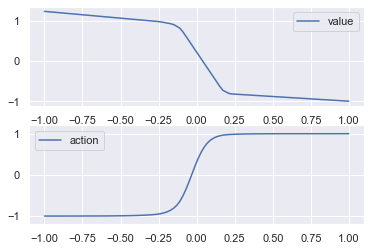

In [294]:
class ProbabilisticFFNetwork(nn.Module):
    # One input, one output, two hidden layers

    def __init__(self, n_hidden):
        super(ProbabilisticFFNetwork, self).__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.fc3 = nn.Linear(in_features=n_hidden, out_features=1)
    
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        mean = torch.tanh(self.fc3(h))
        return mean
    
    def sample(self, x):
        mu = self.forward(x)
        return mu + 0.2*torch.randn_like(mu)


value_net = FFNetwork(100)
policy_net = ProbabilisticFFNetwork(200)

optimizer_value = optim.Adam(value_net.parameters(), lr=0.01, eps=0.1, weight_decay=0.01)
optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.001, eps=0.1, weight_decay=0.01)

for i in range(3000):
    # Environment: contextual bandit
    obs = 2.0 * (torch.rand(1) - 0.5)
    action = policy_net.sample(input).detach()
    if obs > 0:
        if action[0] >= 0:
            reward = +1.0
        else:
            reward = -1.0
    else:
        if action[0] >= 0:
            reward = -1.0
        else:
            reward = +1.0
    #print(f"{obs} : {action} : {reward}")

    # Updates
    optimizer_value.zero_grad()
    optimizer_policy.zero_grad()

    # Value Update
    loss_value = torch.square(value_net(obs) - torch.tensor([reward]))
    loss_value.backward()
    optimizer_value.step()

    # Policy Update
    td_error = reward - value_net(obs)
    mean = policy_net(obs)
    loss_policy = td_error.detach() * torch.square(action - mean)
    loss_policy.backward()
    optimizer_policy.step()

x = torch.tensor([[v] for v in np.linspace(-1, 1, 100)], dtype=torch.float)
val = value_net(x).detach()
u = policy_net(x).detach()

plt.subplot(2,1,1)
plt.plot(x, val,label="value")
plt.legend(loc="best")
plt.subplot(2,1,2)
plt.plot(x, u,label="action")
plt.ylim([-1.2, 1.2])
plt.legend(loc="best")

### Use noisy weight $f(x, \theta + \epsilon)$, $\epsilon \sim {\cal N}(1, 0)$

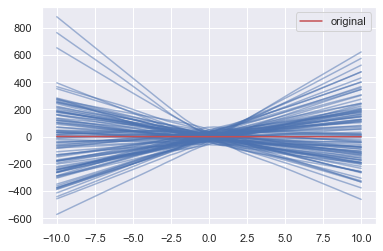

In [326]:
from collections import OrderedDict

ffnet1 = FFNetwork(50)
ffnet2 = FFNetwork(50)

# Plot
x = torch.tensor([[v] for v in np.linspace(-10, 10, 100)], dtype=torch.float)

for i in range(100):
    # Weight fluctuation
    dict_new = OrderedDict(
        [(k, v + torch.randn_like(v)) for (k, v) in ffnet1.state_dict().items()]
    )
    ffnet2.load_state_dict(dict_new)
    # Plot
    plt.plot(x, ffnet2(x).detach(), "b", alpha=0.5)
    
plt.plot(x, ffnet1(x).detach(), "r", label="original")
plt.legend(loc="best")

### Update $\theta$ by the approximated variational method

# Convolution Neural Networks

### Define CNN $f_\theta(x)$

### Update weight by minibatch for CNN

### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$ for CNN

# Recurrent Neural Networks

### Define RNN $f_\theta(x_0, x_1, \dots, x_T)$

### Update weight by minibatch for RNN

### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$ for RNN